# Proyecto final - Parte 1

Bazúa Lobato María del Mar y<br>
Medina Islas Néstor Enrique <br>

## Objetivo

Cómo se mencionó en la propuesta, el objetivo del proyecto es identificar los distintos objetos dentro de un refrigerador en tiendas de abarrotes.
Utilizando el modelo SAM (Segment Anything Model) como punto de partida nos gustaría saber si es posible poder identificar y distinguir las bebidas que se encuentran en el refrigerador para poder hacer un conteo de las mismas.

## Arquitectura del modelo SAM

Las Redes Neuronales Convolucionales (CNN) y las Redes Generativas Antagónicas (GAN) desempeñan un papel fundamental en el modelo SAM


In [3]:
# Primero, verificar que estamos en Colab
from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


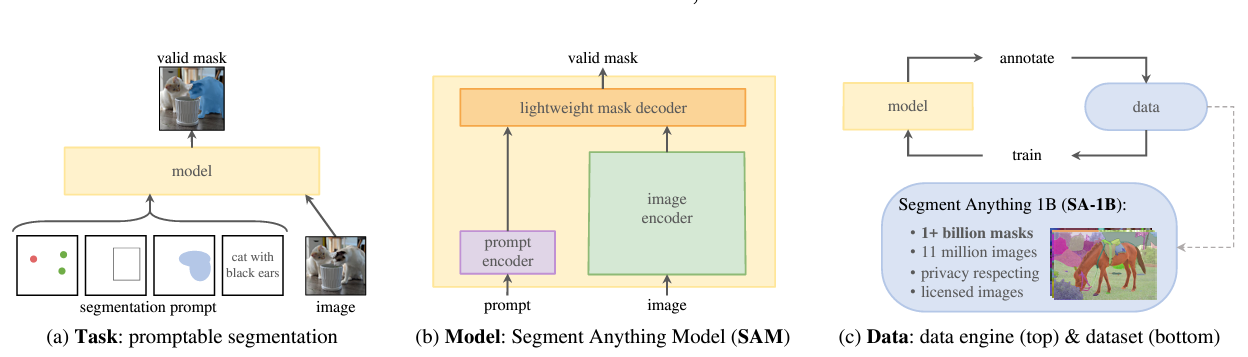

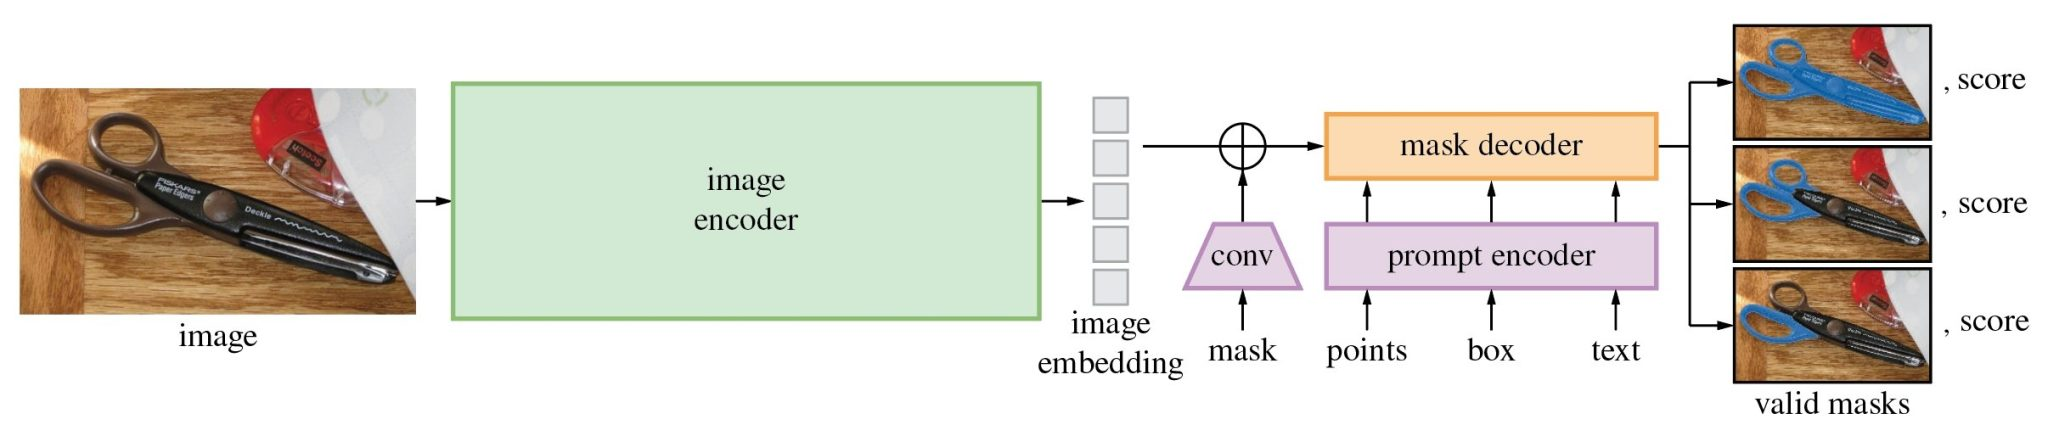

In [4]:
from IPython.display import Image, display

img_path = '/content/drive/My Drive/Colab Notebooks/Proyecto_final/SAM-Network-Architecture-and-Design.png'  # adjust this path
display(Image(filename=img_path))

img_path2 = '/content/drive/My Drive/Colab Notebooks/Proyecto_final/architecture-segment-anything-model-sam.jpg'  # adjust this path
display(Image(filename=img_path2))

## Instalar SAM y las librerías necesarias

In [5]:
!pip install -q  segment_anything
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

  Preparing metadata (setup.py) ... done


Se descargan también los pesos del SAM

In [6]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

import os
HOME = os.getcwd();print("HOME:", HOME);CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

### Lo tuvimos que poner dos veces porque si no fallaba
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

HOME = os.getcwd();print("HOME:", HOME);CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True
HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True


Descargamos las demás librerías necesarias.

In [7]:
from datetime import datetime, timedelta
import torch
import json
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image, ExifTags
import numpy as np
import matplotlib.pyplot as plt
import cv2
import supervision as sv

# Definición de funciones

In [8]:
def binarize_mask(mask, threshold=0.5):
    #Convierte una máscara de valores continuos a una máscara binaria usando un umbral.
    return (mask > threshold).astype(np.uint8)

def remove_small_objects(mask, min_size=500):
    #Elimina regiones pequeñas de una máscara binaria. Esto ayuda a limpiar ruido o detalles irrelevantes.
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    new_mask = np.zeros((output.shape), dtype=np.uint8)
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            new_mask[output == i + 1] = 1
    return new_mask

def save_combined_mask_image(masks, save_path='resultado_imagen.png'):
    #Combina varias máscaras y guarda una imagen con esas regiones resaltadas usando colores.
    combined_mask = np.sum(masks, axis=0)
    height, width = combined_mask.shape[:2]
    fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
    ax.imshow(combined_mask, cmap="jet", alpha=0.5)
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(save_path, dpi=100)
    plt.close(fig)


def correct_image_orientation(image):
    #Ajusta la orientación de una imagen según su metadata EXIF (si está disponible).
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = image._getexif()
        if exif is not None:
            orientation = exif[orientation]
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass
    return image

def remove_logo_regions(mask, min_size=100):
    #Filtra regiones pequeñas de una máscara binaria, como logotipos o detalles menores.
    num_labels, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    sizes = stats[1:, -1]  # Excluir fondo
    new_mask = np.zeros_like(mask)
    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            new_mask[output == i + 1] = 1
    return new_mask

def sam_mask(path, save_path, mostrar_comparacion=False):
    #Aplica el modelo SAM (Segment Anything Model) para detectar y contar objetos en una imagen.
    #También permite visualizar una comparación entre la imagen original y la segmentación generada.
    image = Image.open(path)
    image = correct_image_orientation(image)
    image = image.resize((image.width // 2, image.height // 2))  # Reducir tamaño de la imagen
    image = np.array(image)

    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    MODEL_TYPE = "vit_h"
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,points_per_side=32,  # Menos puntos para evitar sobresegmentación
        pred_iou_thresh=0.9,stability_score_thresh=0.95,
        crop_n_layers=0,min_mask_region_area=3500,
    )
    masks = mask_generator.generate(image)
    masks_tmp = [mask_data['segmentation'] for mask_data in masks]
    filtered_masks = []
    total_objects = 0
    for mask in masks_tmp:
        bin_mask = binarize_mask(mask)
        filtered_mask = remove_small_objects(bin_mask)
        filtered_mask = remove_logo_regions(filtered_mask, min_size=4000)  # Filtrar logotipos o detalles
        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(filtered_mask, connectivity=8)
        object_count = (num_labels - 1)
        if object_count > 0:
            total_objects += object_count
            filtered_masks.append(filtered_mask)

    save_combined_mask_image(filtered_masks, save_path)
    print(f"Objetos detectados: {total_objects}")

    if mostrar_comparacion:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(image); axs[0].set_title("Imagen original");axs[0].axis('off')
        axs[1].imshow(np.sum(filtered_masks, axis=0), cmap="jet", alpha=0.5);axs[1].set_title("Imagen con máscaras SAM");axs[1].axis('off')
        plt.tight_layout();plt.show()

    del sam  # Liberar memoria
    torch.cuda.empty_cache()  # Vaciar caché de la GPU


## Ejecución del modelo

Tenemos 10 imágenes de refrigeradores, corremos el modelo de 3 en 3 para ir analizando los resultados.

In [ ]:
# Carpetas
input_folder = "/content/drive/My Drive/Colab Notebooks/Proyecto_final/Refris/"
output_folder = "/content/drive/My Drive/Colab Notebooks/Proyecto_final/Refris/SAM/"

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)
# Extensiones válidas
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
# Archivos válidos
valid_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)])
# Variable global para llevar el control del índice
start_index = 0; batch_size = 10

def procesar_lote(batch_size=10):
    global start_index  # para actualizar el índice entre ejecuciones
    end_index = min(start_index + batch_size, len(valid_files))
    batch = valid_files[start_index:end_index]

    if not batch:
        print("No quedan más imágenes por procesar.")
        return

    #print(f"Procesando imágenes {start_index + 1} a {end_index} de {len(valid_files)}...\n")

    for filename in batch:
        input_path = os.path.join(input_folder, filename)
        name, ext = os.path.splitext(filename)
        output_filename = f"{name}_SAM{ext}"
        output_path = os.path.join(output_folder, output_filename)

        try:
            sam_mask(input_path, output_path, True)

        except Exception as e:
            print(f"Error al procesar {filename}: {e}")

    start_index = end_index  # actualizar índice

Objetos detectados: 24


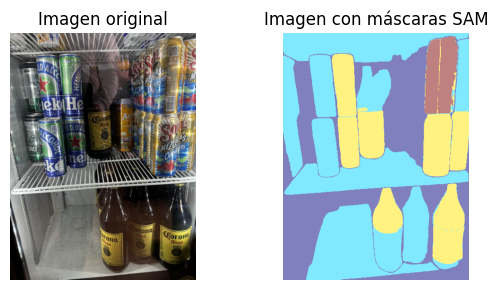

Objetos detectados: 15


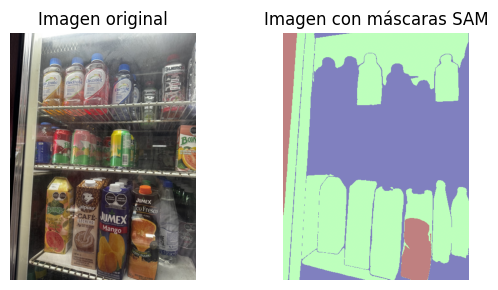

Objetos detectados: 72


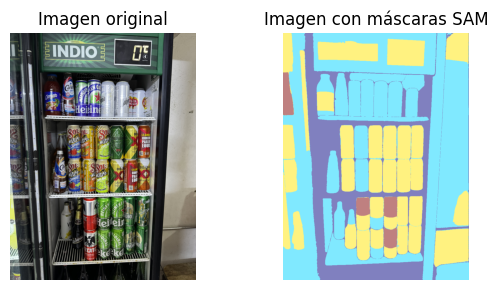

Objetos detectados: 11


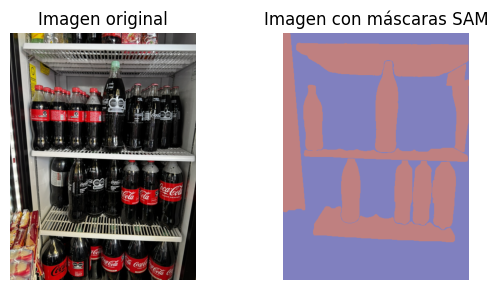

Objetos detectados: 5


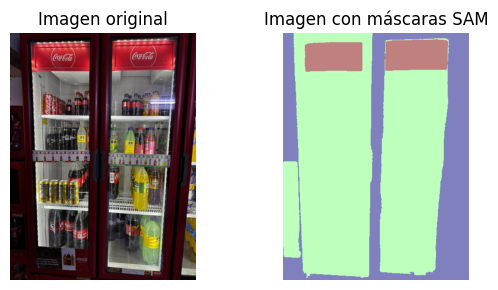

Objetos detectados: 38


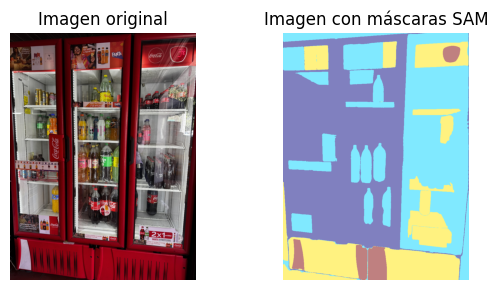

Objetos detectados: 9


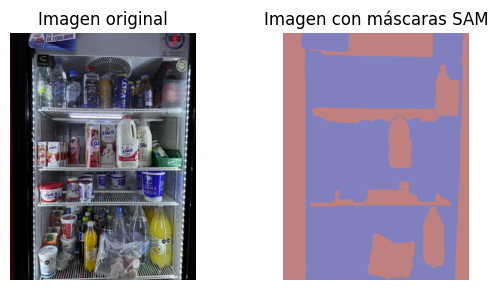

Objetos detectados: 50


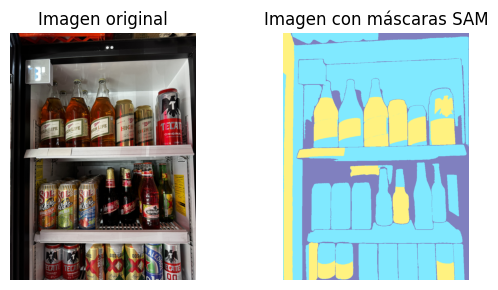

Objetos detectados: 63


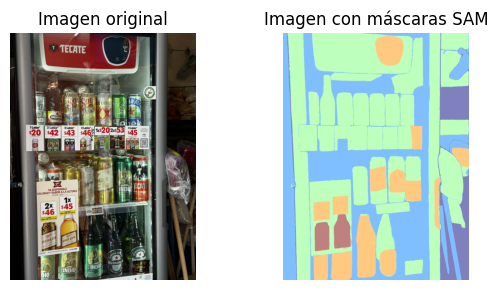

Objetos detectados: 50


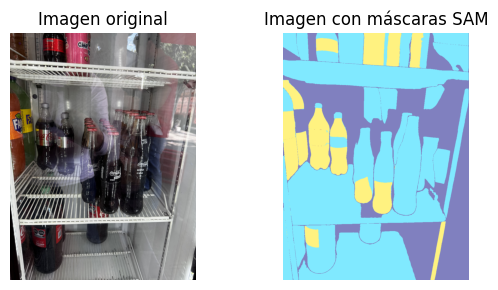

In [ ]:
procesar_lote(batch_size=10)

# Conclusiones

El modelo SAM nos permitió identificar los objetos en los refrigeradores y hacer un conteo aproximado de los objetos en cada uno de ellos.
Desgraciadamente, el modelo falló en identicar los objetos en algunos de los refrigeradores al no poder distinguirlos. Además el conteo en algunos casos estaba subestimado y en otros sobrestimado. Debido a esto, decidimos explorar otras opciones de modelos.
